In [1]:
import torch
from torch import  autograd
from torch import Tensor
from torch import nn
from torch import optim

from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
from sklearn.model_selection import train_test_split

import numpy as np
from pyDOE import lhs         #Latin Hypercube Sampling
from scipy import io
from scipy.stats import median_abs_deviation as MAD
from scipy. integrate import solve_bvp
import pandas as pd
import pickle as pkl
from tqdm import tqdm
from time import time
import warnings
from os.path import exists
from os import makedirs, listdir, remove
warnings.filterwarnings("ignore")
try:plt.style.use('../figstyle.mplstyle')
except:pass

from PINNODE import FCN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
ProblemSetup = {}
nEpochs = 5000
lr = 1e-3
layers = np.array([1,50,50,20,50,50,1])
total_points=500
Nu=2;Nf=250

## Poison 1d
problem:
$$\frac{\partial^2y}{\partial x^2}=-\pi^2sin(\pi x)\quad u(-1)=u(1)=0$$

In [3]:
def f_BC(x):
    return 1-torch.abs(x)
def f_real(x):
    return torch.sin(np.pi*x)
def PDE(x):
    return -1*(np.pi**2)*torch.sin(np.pi*x)

xmin,xmax = -1,1

x = torch.linspace(xmin,xmax,total_points).view(-1,1) #prepare to NN
y = f_real(x)

BC_1=x[0,:]
BC_2=x[-1,:]
# Total Tpaining points BC1+BC2
all_train=torch.vstack([BC_1,BC_2])
#Select Nu points
idx = np.random.choice(all_train.shape[0], Nu, replace=False) 
x_BC=all_train[idx]
#Select Nf points
# Latin Hypercube sampling for collocation points 
x_PDE = BC_1 + (BC_2-BC_1)*lhs(1,Nf)
x_PDE = torch.vstack((x_PDE,x_BC)) 

y_BC=f_BC(x_BC).to(device)

#Store tensors to GPU

x_PDE=x_PDE.float().to(device)
x_BC=x_BC.to(device)

'Loss Functions'
#Loss BC
def lossBC(model,x_BC,y_BC):
    loss_BC=model.criterion(model.forward(x_BC),y_BC)
    return loss_BC
#Loss PDE
def lossPDE(model,x_PDE,PDE):
    g=x_PDE.clone()
    g.requires_grad=True #Enable differentiation
    f=model.forward(g)
    f_x=autograd.grad(f,g,torch.ones([x_PDE.shape[0],1]).to(device),retain_graph=True, create_graph=True)[0] #first derivative
    f_xx=autograd.grad(f_x,g,torch.ones([x_PDE.shape[0],1]).to(device), create_graph=True)[0] #second derivative
    return model.criterion(f_xx,PDE(g))

def Loss(model,x_BC,y_BC,x_PDE,lossPDE,lossBC,PDE):
    loss_bc=lossBC(model,x_BC,y_BC)
    loss_pde=lossPDE(model,x_PDE,PDE)
    return loss_bc+loss_pde
ProblemSetup['Poisson1D'] = {'Loss':Loss, 'LossParams':[x_BC,y_BC,x_PDE,lossPDE,lossBC,PDE],'x':x,'f_real':y}



## Temperature profile:

Find the temperature profile inside the tube wall. Hot fluid flows inside the tube such that the inside temperature is $100^\circ C$. The differential equation for the temperature distribution is given by
$$\frac{d^2T}{dr^2}+\frac{1}{r}\frac{dT}{dr}=0$$
The boundary conditions are $T(100)=100^\circ C$ and $T(150)=0^\circ C$.

Problems taken from: https://documents.uow.edu.au/~buyung/EngineeringComputingLecture.pdf

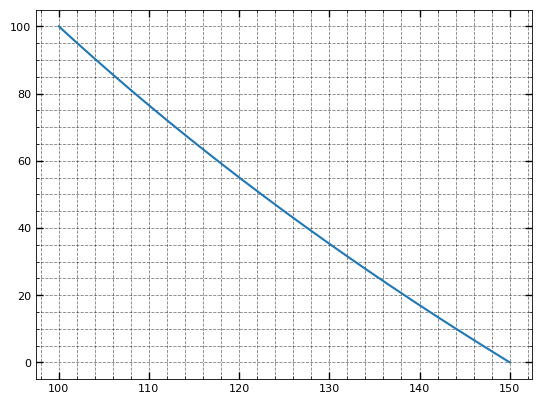

In [4]:
def f_BC(x):
    return -2*(x-150)

def fun(x,y):
    return np.vstack((y[1],-(1/x)*y[1]))
def bc(ya,yb):
    return np.array([ya[0]-100,yb[0]])
def f_real(x):
    xn = x.detach().numpy().reshape((-1))
    y = np.zeros((2,total_points))
    # y[0,:] = np.linspace(100,0,total_points)

    res = solve_bvp(fun,bc,xn,y).sol(xn)[0]
    return res

def PDE(x):
    return torch.zeros(x.size())

xmin,xmax = 100,150
x = torch.linspace(xmin,xmax,total_points).view(-1,1)
y = f_real(x)
plt.plot(x,y)
BC_1=x[0,:]
BC_2=x[-1,:]
# Total Tpaining points BC1+BC2
all_train=torch.vstack([BC_1,BC_2])
#Select Nu points
idx = np.random.choice(all_train.shape[0], Nu, replace=False) 
x_BC=all_train[idx]
#Select Nf points
# Latin Hypercube sampling for collocation points 
x_PDE = BC_1 + (BC_2-BC_1)*lhs(1,Nf)
x_PDE = torch.vstack((x_PDE,x_BC)) 

y_BC=f_BC(x_BC).to(device)

#Store tensors to GPU

x_PDE=x_PDE.float().to(device)
x_BC=x_BC.to(device)
'Loss Functions'
#Loss BC
def lossBC(model,x_BC,y_BC):
    loss_BC=model.criterion(model.forward(x_BC),y_BC)
    return loss_BC
#Loss PDE
def lossPDE(model,x_PDE,PDE):
    g=x_PDE.clone()
    g.requires_grad=True #Enable differentiation
    f=model.forward(g)
    f_x=autograd.grad(f,g,torch.ones([x_PDE.shape[0],1]).to(device),retain_graph=True, create_graph=True)[0] #first derivative
    f_xx=autograd.grad(f_x,g,torch.ones([x_PDE.shape[0],1]).to(device), create_graph=True)[0] #second derivative
    return model.criterion(f_xx+f_x/g,PDE(g))

def Loss(model,x_BC,y_BC,x_PDE,lossPDE,lossBC,PDE):
    loss_bc=lossBC(model,x_BC,y_BC)
    loss_pde=lossPDE(model,x_PDE,PDE)
    return loss_bc+loss_pde
ProblemSetup['TempProf'] = {'Loss':Loss, 'LossParams':[x_BC,y_BC,x_PDE,lossPDE,lossBC,PDE],'x':x,'f_real':y}


## Deflection of Prismatic 
Deflectin of prismatic simply supported bean is given by the following equation.

$$EI\frac{d^2y}{dx^2}=-\frac{qLx}{2}+\frac{dx^2}{2}$$

Where $V$ is uniformly distributed load, L is the length of the beam, I is the moment of inertia of the beam cross section ($I=wh^3/12$, $w$ is width and $h$ is height of the beam) and $E$ is the modulus of elasticity of the beam. For the case in hand $E=10GPa$, $L=2.0m$, $w=5.0cm$, $h=10.0cm$, $V=1500N/m$ and $I=4.166\times10^{-6}m^4$. $y(0)=y(2)=0%, rewrite the governing equation:
$$y''=\frac{Vx}{2EI}(x-L)=0.018x(x-2)$$

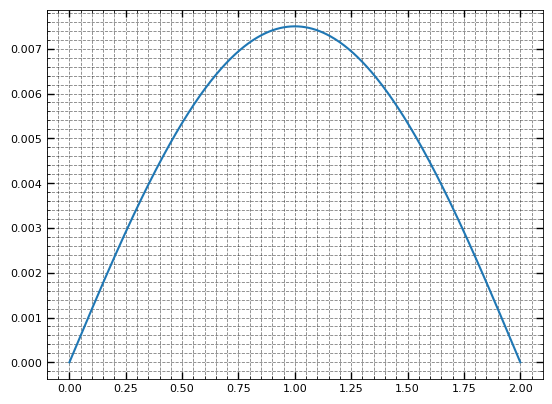

In [5]:
def f_BC(x):
    return 0*x

def fun(x,y):
    return np.vstack((y[1],0.018*x*(x-2)))
def bc(ya,yb):
    return np.array([ya[0],yb[0]])
def f_real(x):
    xn = x.detach().numpy().reshape((-1))
    y = np.zeros((2,total_points))

    res = solve_bvp(fun,bc,xn,y).sol(xn)[0]
    return res

def PDE(x):
    return 0.018*x*(x-2)

xmin,xmax = 0,2
x = torch.linspace(xmin,xmax,total_points).view(-1,1)
y = f_real(x)
plt.plot(x,y)

BC_1=x[0,:]
BC_2=x[-1,:]
# Total Tpaining points BC1+BC2
all_train=torch.vstack([BC_1,BC_2])
#Select Nu points
idx = np.random.choice(all_train.shape[0], Nu, replace=False) 
x_BC=all_train[idx]
#Select Nf points
# Latin Hypercube sampling for collocation points 
x_PDE = BC_1 + (BC_2-BC_1)*lhs(1,Nf)
x_PDE = torch.vstack((x_PDE,x_BC)) 

y_BC=f_BC(x_BC).to(device)

#Store tensors to GPU

x_PDE=x_PDE.float().to(device)
x_BC=x_BC.to(device)
'Loss Functions'
#Loss BC
def lossBC(model,x_BC,y_BC):
    loss_BC=model.criterion(model.forward(x_BC),y_BC)
    return loss_BC
#Loss PDE
def lossPDE(model,x_PDE,PDE):
    g=x_PDE.clone()
    g.requires_grad=True #Enable differentiation
    f=model.forward(g)
    f_x=autograd.grad(f,g,torch.ones([x_PDE.shape[0],1]).to(device),retain_graph=True, create_graph=True)[0] #first derivative
    f_xx=autograd.grad(f_x,g,torch.ones([x_PDE.shape[0],1]).to(device), create_graph=True)[0] #second derivative
    return model.criterion(f_xx,PDE(g))

def Loss(model,x_BC,y_BC,x_PDE,lossPDE,lossBC,PDE):
    loss_bc=lossBC(model,x_BC,y_BC)
    loss_pde=lossPDE(model,x_PDE,PDE)
    return loss_bc+loss_pde
ProblemSetup['Deflection'] = {'Loss':Loss, 'LossParams':[x_BC,y_BC,x_PDE,lossPDE,lossBC,PDE],'x':x,'f_real':y}

## Generic Problem

$$y''=4(y-x)\quad y(0)=0;\,y(1)=2$$
Analitical solution
$$y(x)=\frac{e^2}{e^4-1}(e^{2x}-e^{-2x})+x$$

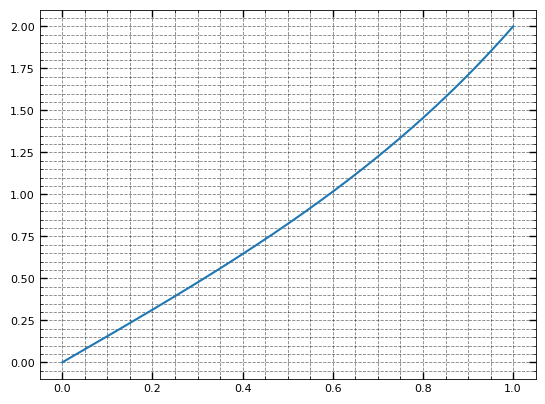

In [6]:
def f_BC(x):
    return 2*x

def fun(x,y):
    return np.vstack((y[1],4*(y[0]-x)))
def bc(ya,yb):
    return np.array([ya[0],yb[0]-2])
def f_real(x):
    xn = x.detach().numpy().reshape((-1))
    y = np.zeros((2,total_points))

    res = solve_bvp(fun,bc,xn,y).sol(xn)[0]
    return res

def PDE(x):
    return -4*x

xmin,xmax = 0,1
x = torch.linspace(xmin,xmax,total_points).view(-1,1)
y = f_real(x)
plt.plot(x,y)

BC_1=x[0,:]
BC_2=x[-1,:]
# Total Tpaining points BC1+BC2
all_train=torch.vstack([BC_1,BC_2])
#Select Nu points
idx = np.random.choice(all_train.shape[0], Nu, replace=False) 
x_BC=all_train[idx]
#Select Nf points
# Latin Hypercube sampling for collocation points 
x_PDE = BC_1 + (BC_2-BC_1)*lhs(1,Nf)
x_PDE = torch.vstack((x_PDE,x_BC)) 

y_BC=f_BC(x_BC).to(device)

#Store tensors to GPU

x_PDE=x_PDE.float().to(device)
x_BC=x_BC.to(device)
'Loss Functions'
#Loss BC
def lossBC(model,x_BC,y_BC):
    loss_BC=model.criterion(model.forward(x_BC),y_BC)
    return loss_BC
#Loss PDE
def lossPDE(model,x_PDE,PDE):
    g=x_PDE.clone()
    g.requires_grad=True #Enable differentiation
    f=model.forward(g)
    f_x=autograd.grad(f,g,torch.ones([x_PDE.shape[0],1]).to(device),retain_graph=True, create_graph=True)[0] #first derivative
    f_xx=autograd.grad(f_x,g,torch.ones([x_PDE.shape[0],1]).to(device), create_graph=True)[0] #second derivative
    return model.criterion(f_xx-4*f,PDE(g))

def Loss(model,x_BC,y_BC,x_PDE,lossPDE,lossBC,PDE):
    loss_bc=lossBC(model,x_BC,y_BC)
    loss_pde=lossPDE(model,x_PDE,PDE)
    return loss_bc+loss_pde
ProblemSetup['GenProb1'] = {'Loss':Loss, 'LossParams':[x_BC,y_BC,x_PDE,lossPDE,lossBC,PDE],'x':x,'f_real':y}

## Generic problem

$$y''=y^3-yy'\quad y(1)=1/2;\;y(2)=1/3$$
Analitical solution:

$$y(x)=\frac{1}{x+1}$$

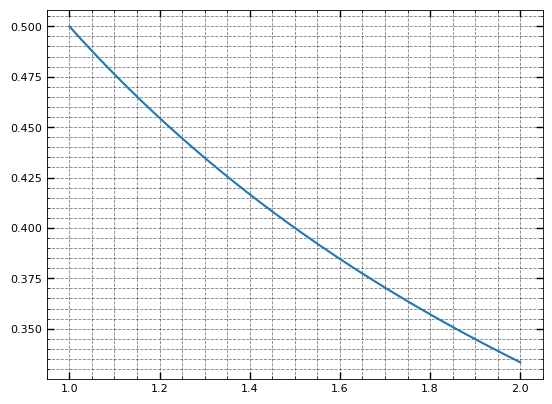

In [7]:
def f_BC(x):
    return 1/2 - (x-1)/6

def fun(x,y):
    return np.vstack((y[1],y**3-y[0]*y[1]))
def bc(ya,yb):
    return np.array([ya[0]-1/2,yb[0]-1/3])
def f_real(x):
    return 1/(x+1)

def PDE(x):
    return torch.zeros(x.size())

xmin,xmax = 1,2
x = torch.linspace(xmin,xmax,total_points).view(-1,1)
y = f_real(x)
plt.plot(x,y)

BC_1=x[0,:]
BC_2=x[-1,:]
# Total Tpaining points BC1+BC2
all_train=torch.vstack([BC_1,BC_2])
#Select Nu points
idx = np.random.choice(all_train.shape[0], Nu, replace=False) 
x_BC=all_train[idx]
#Select Nf points
# Latin Hypercube sampling for collocation points 
x_PDE = BC_1 + (BC_2-BC_1)*lhs(1,Nf)
x_PDE = torch.vstack((x_PDE,x_BC)) 

y_BC=f_BC(x_BC).to(device)

#Store tensors to GPU

x_PDE=x_PDE.float().to(device)
x_BC=x_BC.to(device)
'Loss Functions'
#Loss BC
def lossBC(model,x_BC,y_BC):
    loss_BC=model.criterion(model.forward(x_BC),y_BC)
    return loss_BC
#Loss PDE
def lossPDE(model,x_PDE,PDE):
    g=x_PDE.clone()
    g.requires_grad=True #Enable differentiation
    f=model.forward(g)
    f_x=autograd.grad(f,g,torch.ones([x_PDE.shape[0],1]).to(device),retain_graph=True, create_graph=True)[0] #first derivative
    f_xx=autograd.grad(f_x,g,torch.ones([x_PDE.shape[0],1]).to(device), create_graph=True)[0] #second derivative
    return model.criterion(f_xx-f**3+f*f_x,PDE(g))

def Loss(model,x_BC,y_BC,x_PDE,lossPDE,lossBC,PDE):
    loss_bc=lossBC(model,x_BC,y_BC)
    loss_pde=lossPDE(model,x_PDE,PDE)
    return loss_bc+loss_pde
ProblemSetup['GenProb2'] = {'Loss':Loss, 'LossParams':[x_BC,y_BC,x_PDE,lossPDE,lossBC,PDE],'x':x,'f_real':y}

In [8]:
ProblemSetup.keys()

dict_keys(['Poisson1D', 'TempProf', 'Deflection', 'GenProb1', 'GenProb2'])

In [9]:
fig, ax = plt.subplots(1,figsize=(16,10))
colors = ['b','r','g','y','m']
torch.manual_seed(123)
for i,problem in enumerate(ProblemSetup.keys()):
    fig2, ax2 = plt.subplots(1,figsize=(16,10))
    print(f'Considering problem: {problem}')
    t0 = time()
    model = FCN(layers,ProblemSetup[problem]['Loss'],lr=0.001,optimizer='Adam')#,scheduler='StepLR',argschedu={'step_size':500,'gamma':0.6})
    model.Train(ProblemSetup[problem]['LossParams'],10000)
    print(time()-t0)
    yh = model(ProblemSetup[problem]['x']).detach().numpy()
    ax2.plot(ProblemSetup[problem]['x'],yh,ls='-',color=colors[i],label='Predicted')
    try:ax2.plot(ProblemSetup[problem]['x'],ProblemSetup[problem]['f_real'],ls='-',color='k',label='Real')
    except:print(f'Problem with {problem} real fun')
    ax2.legend(frameon=False,title='Solutions:')
    fig2.savefig(f'Figures/DiffProblems{problem}2.pdf',bbox_inches='tight')
    fig2.savefig(f'Figures/DiffProblems{problem}2.png',bbox_inches='tight')
    plt.close(fig2)
    ax.plot(model.loss_history,ls='-',color=colors[i],label=problem)
    del model, yh
ax.legend(frameon=False,title = 'Problems')
ax.set_yscale('log')
fig.savefig('Figures/DiffProblemsLossComp2.pdf',bbox_inches='tight')
fig.savefig('Figures/DiffProblemsLossComp2.png',bbox_inches='tight')
plt.close(fig)

Considering problem: Poisson1D
71.05565619468689
Considering problem: TempProf
73.92451691627502
Considering problem: Deflection
72.84736633300781
Considering problem: GenProb1
70.19469451904297
Considering problem: GenProb2
74.76588582992554
